##  Creating the DB
This document is solely for testing localy, i am not sure if it can be applied to the current code but i will try my best to make it as compatible as possible

In [1]:
#### imports needed
import sqlite3 
import os
import pandas as pd

### "Pre processing" the data 
it would be great to have the file path with it in each data frame
(this is nearly identical to what Anna is doing)

In [ ]:
%pip install openpyxl

In [3]:
df = pd.read_excel('content\ground_truth\data.xlsx')
ground_truth_df = df[['Study_ID', 'Study', 'Allocation', 'Experimenter']]
ground_truth_df

,Study_ID,Study,Allocation,Experimenter
0,1,Chacko et al 2017,Random,Parent
1,1,Chacko et al 2017,Random,Parent
2,2,Coyne et al 2004,Non-random,Teacher
3,2,Coyne et al 2004,Non-random,Teacher
4,3,Purpura et al 2017,Random,Researcher
...,...,...,...,...
311,54,Hassinger-Das (2013),Random,Researcher
312,54,Hassinger-Das (2013),Random,Researcher
313,54,Hassinger-Das (2013),Random,Researcher
314,27,Crandell 2010,Random,Teacher


In [ ]:
# extracting data from the csv files in the extracted directory

extracted_dir = 'content/extracted'
extracted_dfs = []

if os.path.exists(extracted_dir):
    for filename in os.listdir(extracted_dir):
        if filename.endswith('.csv'):
            file_path = os.path.join(extracted_dir, filename)
            try:
                df = pd.read_csv(file_path)
                extracted_dfs.append(df)
                print(f"Loaded {filename}")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

if extracted_dfs:
    extracted_combined_df = pd.concat(extracted_dfs, ignore_index=True)
    print("Combined DataFrame created.")
else:
    print("No CSV files found in the directory.")

In [5]:
# directly taken from Anna's code
import re
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

def format_studyName(study_name_string):
    """
    Cuts a string after the last four-digit number, assuming it represents the year.

    Args:
        study_name_string (str): The input string potentially containing a year.

    Returns:
        str: The string cut after the year, or the original string if no year is found.
    """
    # Get rid of all the points, -
    study_name_string = study_name_string.replace('.', '')
    study_name_string = study_name_string.replace(',', '')
    study_name_string = study_name_string.replace(' - ', ' ')
    study_name_string = study_name_string.replace(')', '')
    study_name_string = study_name_string.replace('(', '')
    study_name_string = study_name_string.replace('&', 'and')
    study_name_string = remove_accents(study_name_string)
    # Find all occurrences of four consecutive digits (potential years)
    year_matches = list(re.finditer(r'\b\d{4}\b', study_name_string))

    if year_matches:
        # Get the last match
        last_year_match = year_matches[-1]
        # Get the end index of the last year match
        end_of_year_index = last_year_match.end()
        # Slice the string up to the end of the year
        cut_string = study_name_string[:end_of_year_index]
        return cut_string.strip() # Use strip to remove trailing whitespace
    else:
        # If no four-digit number is found, return the original string
        return study_name_string.strip()

In [6]:
extracted_combined_df['Study'] = extracted_combined_df['Study'].apply(format_studyName)
extracted_combined_df

,Allocation,Experimenter,Study
0,Random,Teacher,Joint storybook reading and joint writing inte...
1,Non-random,Teacher,Bianco et al 2010
2,Random,Teacher,Biemiller and Boote 2006
3,Random,Parent,Instructing Parents to Use Dialogic Reading St...
4,Random,Researcher,Coyne et al 2004
5,Random,Teacher,Coyne et al 2010
6,Random,Researcher,Efeitos da Leitura de Historias no Desenvolvim...
7,Random,Teacher,Korat and Shamir 2007
8,Random,Parent,Korat et al 2013
9,Researcher,Lefebvre et al. - 2011 - Enhancing vocabulary,print awareness and phonological awareness thr...


### Loading the dataBase

In [7]:
# TODO 1 done: change it so it takes a data frame as input

def creatingDB(gt, extracted, table_nameGt, table_name_extracted):
  '''creates a SQLite database with the same structure as the given DataFrame and inserts the data into it.'''
  
  # Connect to database
  conn = sqlite3.connect('content/database.db')

  # Dropping the tables if they exist
  conn.execute(f"DROP TABLE IF EXISTS {table_nameGt}")
  conn.execute(f"DROP TABLE IF EXISTS {table_name_extracted}")

  # Automatically create table with same name and structure
  gt.to_sql(table_nameGt, conn, if_exists='append', index=False)
  extracted.to_sql(table_name_extracted, conn, if_exists='append', index=False)

  print("Tables created with the same structure as the CSV and data inserted.")
  
  # Done
  conn.commit()
  conn.close()

In [8]:
gt_table = 'Ground_truth'
extracted_table = 'Extracted'
creatingDB(ground_truth_df, extracted_combined_df, gt_table, extracted_table)

Tables created with the same structure as the CSV and data inserted.


## Calculating the metrics
Auxilary functions used to calculate the metrics just so it can be easier to read

In [26]:
#TODO : it would be great to have a class that has all those at the same time

def calculateAccuracy(TP, FP, FN):
    '''calculates the accuracy of a model based on true positives, true negatives, false positives, and false negatives.'''
    return TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

def calculatePrecision(TP, FP):
    '''calculates the precision of a model based on true positives and false positives.'''
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def calculateRecall(TP, FN):
    '''calculates the recall of a model based on true positives and false negatives.'''
    return TP / (TP + FN) if (TP + FN) > 0 else 0

def calculateF1Score(precision, recall):
    '''calculates the F1 score based on precision and recall.'''
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def calculateMetrics(TP, FP, FN):
    '''calculates various metrics based on true positives, false positives, and false negatives.'''
    # --- Metrics ---
    accuracy = calculateAccuracy(TP, FP, FN) 
    recall = calculateRecall(TP, FN)
    precision = calculatePrecision(TP, FP)
    f1 = calculateF1Score(precision, recall)

    return {
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'Precision': round(precision, 4),
        'F1': round(f1, 4)
    }

#testing the metrics
'''
Example usage of the calculateMetrics function
metrics = calculateMetrics(10, 5, 2)
print(metrics)
'''

'\nExample usage of the calculateMetrics function\nmetrics = calculateMetrics(10, 5, 2)\nprint(metrics)\n'

## SQL queries

In [ ]:
def printAllTables():
    '''affiche toutes les tables de la base de données.'''

    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    # testing if the data is inserted correctly
    cursor.execute(f"SELECT * FROM {gt_table} LIMIT 15;")
    print("Ground Truth Table:")
    for row in cursor.fetchall():
        print(row)

    cursor.execute(f"SELECT * FROM {extracted_table} ;")
    print("\nExtracted Table:")
    for row in cursor.fetchall():
        print(row)

    conn.commit()
    conn.close()

def countElements():
    '''counts the number of elements in each table and prints the result.'''

    conn = sqlite3.connect('content/database.db')
    cursor = conn.cursor()

    # testing if the data is inserted correctly
    cursor.execute(f"SELECT COUNT(*) FROM {gt_table};")
    print("Ground Truth Table count:")
    print(cursor.fetchall()[0])
        

    cursor.execute(f"SELECT COUNT(*) FROM {extracted_table} ;")
    print("\nExtracted Table count:")
    print(cursor.fetchall()[0])

    cursor.execute(f"""
        SELECT COUNT(ext.Study)
        FROM {gt_table} AS gt
                JOIN {extracted_table} AS ext ON gt.Study = ext.Study
        """)
    print("Total matched rows:", cursor.fetchone()[0])


    conn.commit()
    conn.close()

countElements()
#printAllTables()

Ground Truth Table count:
(316,)

Extracted Table count:
(19,)
Total matched rows: 31


### For binary values

In [ ]:
def truePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'Random' (1)
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    cursor.execute(f"""
        SELECT COUNT(*) 
        FROM {gt} AS gt 
            JOIN {extracted} AS ext ON gt.Study = ext.Study 
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    TP_count = result[0]
    
    print(f"Number of True Positives for '{column}': {TP_count}")

    conn.commit()
    conn.close()
    return TP_count

def falsePositives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random' ):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Random (1) and extracted (model output) = Non-random (0)
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} = '{positiveValue}' AND ext.{column} != '{positiveValue}'
    """)
    result = cursor.fetchone()
    FP_count = result[0]
    
    print(f"Number of false Positives for '{column}': {FP_count}")

    conn.commit()
    conn.close()

    return FP_count

def falseNegatives(conn, gt, extracted, column = 'Allocation', positiveValue = 'Random'):
    '''calculates the number of true positives based on ground truth and extracted data.
        where gt = Non-random (0) and extracted (model output) = Random (1)
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        SELECT COUNT(*) FROM {gt} AS gt
        JOIN {extracted} AS ext ON gt.Study = ext.Study
        WHERE gt.{column} != '{positiveValue}' AND ext.{column} = '{positiveValue}'
    """)
    result = cursor.fetchone()
    FN_count = result[0]
    
    print(f"Number of false Negatives for '{column}': {FN_count}")

    conn.commit()
    conn.close()

    return FN_count

In [27]:
#print("True Positives:")
TP = truePositives('content/database.db', gt_table, extracted_table, 'Allocation')

#print("false Positives:")
FP = falsePositives('content/database.db', gt_table, extracted_table, 'Allocation')

#print("false Negatives:")
FN = falseNegatives('content/database.db', gt_table, extracted_table, 'Allocation')

print("Calculating metrics... : \n", calculateMetrics(TP, FP, FN))

Number of True Positives for 'Allocation': 12
Number of false Positives for 'Allocation': 0
Number of false Negatives for 'Allocation': 4
Calculating metrics... : 
 {'Accuracy': 0.75, 'Recall': 0.75, 'Precision': 1.0, 'F1': 0.8571}


Note : those results seem odd, how is the precision at 100% ??? either my function is wrong or the data isn't big enough (doubt it)

### Exparimenter
basically it's when the selected column can be more then 2 values (non binary), i think it can work with allocation (binary values) but i still did a separate case for it just in case

In [13]:
def truePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of true positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            print(f"True Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falsePositivesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False positives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    TP_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} != '{value}' AND ext.{column} = '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            print(f"False Positives for {value}: {row}")
            TP_count.append(row)
    
    conn.commit()
    conn.close()
    return TP_count

def falseNegativesExperimenter(conn, gt, extracted, column = 'Experimenter', 
                              values = ['Teacher','Parent', 'Researcher', 'Combined - Teacher and Parent']):
    
    '''calculates the number of False nergatives based on ground truth and extracted data.
        where the ground thruth and extracted data both have the value 'teacher', 'parent', 'researcher' or 'Combined - Teacher and Parent'
    '''
    conn = sqlite3.connect(conn)
    cursor = conn.cursor()
    FN_count = []
    for value in values:
        cursor.execute(f"""
            SELECT COUNT(*)
            FROM {gt} AS gt 
                JOIN {extracted} AS ext ON gt.Study = ext.Study
            WHERE gt.{column} = '{value}' AND ext.{column} != '{value}'
        """)
        result = cursor.fetchone()
        for row in result:
            print(f"False negatives for {value}: {row}")
            FN_count.append(row)
    
    conn.commit()
    conn.close()
    return FN_count

In [14]:
TPE = truePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
TPE_sum = sum(TPE)
print("Sum of TPE:", TPE_sum)

True Positives for Teacher: 15
True Positives for Parent: 0
True Positives for Researcher: 2
True Positives for Combined - Teacher and Parent: 0
Sum of TPE: 17


In [15]:
FPE = falsePositivesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FPE_sum = sum(FPE)
print("Sum of FPE:", FPE_sum)

False Positives for Teacher: 2
False Positives for Parent: 0
False Positives for Researcher: 6
False Positives for Combined - Teacher and Parent: 0
Sum of FPE: 8


In [29]:
FNE = falseNegativesExperimenter('content/database.db', gt_table, extracted_table, 'Experimenter')
FNE_sum = sum(FNE)
print("Sum of FNE:", FNE_sum)

False negatives for Teacher: 6
False negatives for Parent: 0
False negatives for Researcher: 2
False negatives for Combined - Teacher and Parent: 0
Sum of FNE: 8


In [30]:
calculateMetrics(TPE_sum, FPE_sum, FNE_sum)

{'Accuracy': 0.5152, 'Recall': 0.68, 'Precision': 0.68, 'F1': 0.68}

In [28]:
#provided by Anna 
def accuracy_check(col_name, df_extracted, test_table):
  allocation_match = False
  experimenter_match = False

  # Check if both dataframes have the expected columns and rows
  if col_name in df_extracted.columns and \
    not df_extracted.empty and not test_table.empty:

      extracted_allocation = df_extracted[col_name].iloc[0]

      ground_truth_allocation = test_table[col_name].iloc[0]

      # Simple case-insensitive comparison
      if str(extracted_allocation).lower() == str(ground_truth_allocation).lower():
          allocation_match = True
          print(f'{col_name}: Match')
      else:
          print(f"{col_name}: Mismatch (Extracted: '{extracted_allocation}', Ground Truth: '{ground_truth_allocation}')")
  else:
    print("Cannot perform accuracy check: Extracted or ground truth data is missing or malformed.")
  print("--------------------")

# To do :
nexts steps are to add graphics
- check what are the appropriate graphics to match this data

# Plots 
plotting the outputted numbers uwu

In [ ]:
%pip install matplotlib
import matplotlib.pyplot as plt

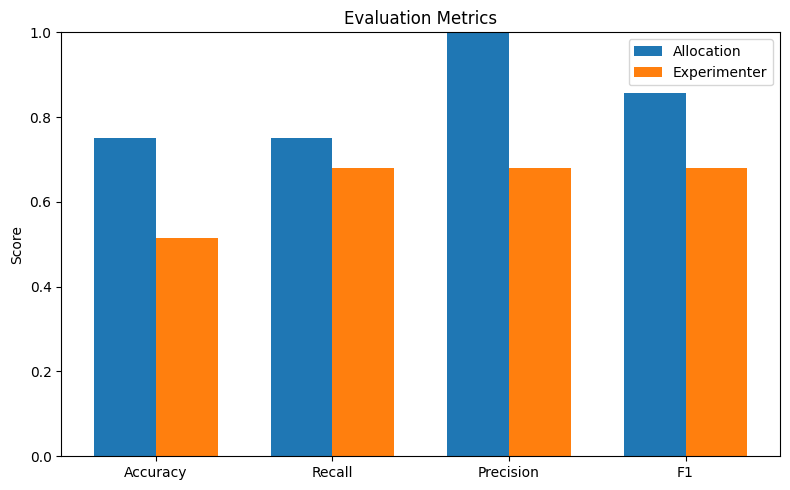

In [32]:
# Metrics for Allocation (binary)
allocation_metrics = calculateMetrics(TP, FP, FN)

# Metrics for Experimenter (multi-class)
experimenter_metrics = calculateMetrics(TPE_sum, FPE_sum, FNE_sum)

# Prepare data for plotting
labels = ['Accuracy', 'Recall', 'Precision', 'F1']
allocation_values = [allocation_metrics[label] for label in labels]
experimenter_values = [experimenter_metrics[label] for label in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], allocation_values, width, label='Allocation')
plt.bar([i + width/2 for i in x], experimenter_values, width, label='Experimenter')

plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()